# Flagging

Demonstration of prototype ngCASA flagging functions. This is work in progress.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/FedeMPouzols/cngi_prototype/blob/ngcasa_flagging_experiments/docs/flagging.ipynb)



## Get required packages and data

In [1]:
# Installation
import os
# (WIP note: we might get by without casatools, if we prepare some .vis.zarr available for download re-check)
print("installing casa6 + cngi (takes a minute or two)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.1.0.118")

os.system("pip install cngi-prototype==0.0.67")

installing casa6 + cngi (takes a minute or two)...


0

In [2]:
# Retrieve and extract demonstration datasets
print('retrieving MS tarfiles...')
!gdown -q --id 15HfB4rJKqEH7df088Ge5YLrCTXBIax6R
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
print('extracting MS tarfiles...')
!tar -xf M100.ms.tar
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz
# TODO: download the ".flagonline.txt" file
print('complete')

retrieving MS tarfiles...
extracting MS tarfiles...
complete


## Initialize the Environment
Omitting for now. I think we don't need it here and it shouldn't show up here at the ngCASA level anyway.

## Load demo data

In [9]:
from cngi.conversion import convert_ms

zarr_name = 'twhya.vis.zarr' 
mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile=zarr_name) 

Completed ddi 0  process time 9.01 sremaining time est 0 s                  
Empty Subtable: POINTINGf 20 : POINTINGE...                        
Empty Subtable: SYSCAL of 20 : SYSCAL                              
Empty Subtable: SYSPOWERf 20 : SYSPOWER
Completed subtables  process time 1.04 sPOSITION...                    
                                                  


In [10]:
from cngi.dio import describe_vis 
describe_vis(zarr_name)
# We will be working with the only SPW present in this dataset
vis_dset = mxds.xds0

## Flag summaries
Summaries of flags by different dimensions in a dictionary, similar to the dictionary produce by CASA flagdata in 'summary' mode.

In [13]:
from ngcasa.flagging import summary
# <temporary hack>
mxds.xds0['presence_baseline'] = mxds.xds0.DATA.notnull().any(['chan', 'pol'])
# </temporary hack>
counts = summary(mxds, 0)
counts

{'correlation': {'XX': {'flagged': 22800, 'total': 30936192},
  'YY': {'flagged': 22800, 'total': 30936192}},
 'total': 61872384,
 'flagged': 45600,
 'array': {'0': {'flagged': 45600, 'total': 61872384}},
 'scan': {'4': {'flagged': 0, 'total': 3225600},
  '7': {'flagged': 45600, 'total': 2918400},
  '10': {'flagged': 0, 'total': 1459200},
  '12': {'flagged': 0, 'total': 6538752},
  '14': {'flagged': 0, 'total': 1459200},
  '16': {'flagged': 0, 'total': 7956480},
  '18': {'flagged': 0, 'total': 1612800},
  '20': {'flagged': 0, 'total': 7926528},
  '22': {'flagged': 0, 'total': 1612800},
  '24': {'flagged': 0, 'total': 7928832},
  '26': {'flagged': 0, 'total': 1612800},
  '28': {'flagged': 0, 'total': 7266816},
  '30': {'flagged': 0, 'total': 1459200},
  '33': {'flagged': 0, 'total': 2612736},
  '34': {'flagged': 0, 'total': 1459200},
  '36': {'flagged': 0, 'total': 3210240},
  '38': {'flagged': 0, 'total': 1612800}},
 'observation': {'0': {'flagged': 45600, 'total': 61872384}},
 'field'

## Handling flag versions




In [17]:
from ngcasa.flagging import manager_list, manager_add, manager_remove
print('* Printing list of flag variables - checkpoint 0:')
versions = manager_list(vis_dset)
print(versions)

vis_flags = manager_add(vis_dset, 'start', 'flags state at start')
# vis_flags = manual_unflag(vis_flags, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
vis_flags = manager_add(vis_flags, 'backup', 'backup description')
#
vis_flags = manager_add(vis_flags, 'final', 'backup second descr')
#
print('* Printing list - checkpoint A:')
versions = manager_list(vis_flags)
print(versions)

# fxds['FLAG'] = fxds['FLAG_final']
vis_flags['FLAG'] = vis_flags['FLAG_backup'] | vis_flags['FLAG_start']

# We can always drop versions that are no longer useful
vis_flags = manager_remove(vis_flags, 'start')
vis_flags = manager_remove(vis_flags, 'backup')
vis_flags = manager_remove(vis_flags, 'final')
print('* Printing list - checkpoint B:')
versions = manager_list(vis_flags)
print(versions)

* Printing list of flag variables - checkpoint 0:
  Flag variable name             Description
0               FLAG  Default flags variable
* Printing list - checkpoint A:
  Flag variable name             Description
0               FLAG  Default flags variable
1         FLAG_start    flags state at start
2        FLAG_backup      backup description
3         FLAG_final     backup second descr
* Printing list - checkpoint B:
  Flag variable name             Description
0               FLAG  Default flags variable


## Running flagging methods
A few illustrative examples, trying to cover all the categories of flagging methods.



### Manual flagging and meta-information based methods
Methods based on data selection and/or meta-information. Simple examples with data selection based flagging and unflagging.

In [20]:
from ngcasa.flagging import manual_flag, manual_unflag

vis_dset = mxds.xds0
#
vis_dset = manager_add(vis_dset, 'checkpointA', 'after a couple of example manual selections')
#
vis_dset = manager_add(vis_dset, 'manual_sels', 'after applying a few manual flags')

vis_unflagged = manual_unflag(mxds, 0)
# <horror> figure out how to deal with return mxds (use cngi._utils._io.vis_xds_packager?)
mxds.xds0['FLAG'] = vis_unflagged['FLAG']
# </horror>
counts = summary(mxds, 0)
print('After unflagging: {}'.format(counts))

flagged_manual = applyflags(vis_dset, flags=['FLAG'])
visplot(flagged_manual.DATA, plot_axes)

TypeError: manual_unflag() missing 1 required positional argument: 'commands'

### Manual flagging with command lists
An example of application of a list of manual flagging commands, resembling use cases from pipelines. An additional required input is the file of flagging commands. Here we use a `.flagonline.txt` file as used in pipelines, where we usually find of the order of 1000s or 10s of thousands of commands. The `.flagonline.txt` is the lion's share of the full list of commands used by pipelines (`.flagcmds.txt`), where the `.flagonline.txt` list of commands is extended with a much shorter list of additional commands that may include a number of summaries, selections based on intent and frequency, the shadow method, etc.

The selection syntax used is the Xarray selection syntax (see examples in the [Visibilities walkthrough ](visibilities.ipynb)), with selection by label `xds.sel(...)`.

In [28]:
vis_flags = manual_unflag(mxds, 0, [{'time': slice('2011-09-16T15:38:17','2011-10-16T18:39:50')}])
#
vis_flags = manual_unflag(mxds, 0, [{}])

# Flag two groups of adjacent ~20 chans
vis_flags = manual_flag(mxds, 0, [{'chan': slice(113.8e9, 113.95e9)}, 
                                  {'chan': slice(115.0e9, 115.16e9)}])

# Flag some baselines, by ID
vis_flags = manual_flag(mxds, 0, [{'baseline': [133, 134, 135]}])
# Flag polarization, by ID
# vis_flgs = manual_flag(vis_flags, [{'pol': 9}])

# vis_dset = manual_flag(vis_dset, cmdfile='.flagonline.txt')
vis_flags = manager_add(vis_flags, 'manual_list', 'after applying list of selection commands')

 *** Going for cmd: {'time': slice('2011-09-16T15:38:17', '2011-10-16T18:39:50', None)}, selection: {'time': slice(numpy.datetime64('2011-09-16T15:38:17'), numpy.datetime64('2011-10-16T18:39:50'), None)}
 *** Going for cmd: {}, selection: {}


NameError: name 'chan' is not defined

### Auto-flagging methods
An illustrative example using the `auto_clip` method. Other auto-flagging methods such as tfcrop, rflag, and uvbin are not implemented.

In [31]:
from ngcasa.flagging import auto_clip
# 
vis_dset = manager_add(vis_dset, 'auto_clip_test', 'after applying clip')
versions = manager_list(vis_dset)
print(versions)

    Flag variable name                                  Description
0                 FLAG                       Default flags variable
1     FLAG_checkpointA  after a couple of example manual selections
2     FLAG_manual_sels            after applying a few manual flags
3       FLAG_auto_clip                          after applying clip
4  FLAG_auto_clip_test                          after applying clip


## Applying flags
To apply a version of flags on a visibilities dataset, before going on to further processing, the function `cngi.vis.applyflags` should be applied. Some examples can be found in the [Continuum Imaging Example](imaging/continuum_imaging_example.ipynb) or the [Visibilities walkthrough](visibilities.ipynb). `cngi.vis.applyflags` sets the flagged data values to NaN. This has the effect that those NaN values are effectively excluded from subsequent CNGI/ngCASA processing. Other components of CNGI and ngCASA, such as imaging, will ignore those NaN values.

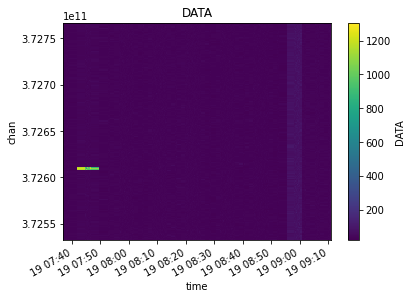

In [36]:
from cngi.vis import applyflags
from cngi.vis import visplot

versions = manager_list(vis_dset)
versions

plot_coords = ['time', 'chan']
visplot(vis_dset.DATA, plot_coords)
vis_dataset_flagged = applyflags(vis_dset, flags=['FLAG'])
# Further processing: visualization, calibration, imaging, etc. with flags applied (flagged data excluded)
# ...

#flagged_manual = applyflags(vis_dset, flags=['FLAG_MANUAL_LIST'])
#visplot(flagged_manual.DATA, plot_coords)

#flagged_clip = applyflags(vis_dset, flags=['FLAG_AUTO_CLIP'])
#visplot(flagged_clip.DATA, plot_coords)